In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(glue))
suppressMessages(library(ggpointdensity))
suppressMessages(library(magrittr))

In [2]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=180)

In [3]:
suppressMessages(library(cowplot))
theme_set(theme_cowplot(font_size = 14))

In [4]:
suppressMessages(library(patchwork))
suppressMessages(library(ggrepel))

In [5]:
getwd()

[1] "/home/chaodai"

In [6]:
setwd("~/cdai/SpliFi/analysis")

# Introduction

preprocessed files are under `data/ds_v_dge`

In [7]:
contrast <- 'Brain-Cortex_v_Muscle-Skeletal'

In [8]:
data <- readRDS(glue('../data/ds_v_dge/{contrast}_data.rds'))

In [9]:
ds <- data$ds
dge <- data$dge
dge_dsc <- data$dge_dsc
rm(data)

In [10]:
ds[1:2,]
dge_dsc
dge[1:2,]

intron,cluster,itype,ctype,gene_name,gene_id,logef,Muscle-Skeletal,Brain-Cortex,deltapsi,status,loglr,df,p,p.adjust
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
chr1:930336:931038:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,0.001370763,0.5276685,0.5283518,0.0006832305,Success,0.0001028596,1,0.9885564,0.9923067
chr1:931089:935771:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,-0.001370763,0.4723315,0.4716482,-0.0006832305,Success,0.0001028596,1,0.9885564,0.9923067


[1] "mean of normalized counts for all samples"                     
[2] "log2 fold change (MLE): tissue Brain.Cortex vs Muscle.Skeletal"
[3] "standard error: tissue Brain.Cortex vs Muscle.Skeletal"        
[4] "Wald statistic: tissue Brain.Cortex vs Muscle.Skeletal"        
[5] "Wald test p-value: tissue Brain.Cortex vs Muscle.Skeletal"     
[6] "BH adjusted p-values"

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000109061.9,264709.9,-13.54712,0.2173014,-62.34253,0,0
ENSG00000168530.15,109266.1,-13.36231,0.1923248,-69.47785,0,0


In [22]:
# get tissue order from contrast, note is tissue2 v tissue 1
tissues <- str_split(contrast, "_v_") %>% unlist
# for ds, col9 is numerator, col8 is denom
confirm_level_ds <- all(names(ds)[c(9,8)] == tissues)
# confirm dge contrast
confirm_level_dge <- str_detect(str_split(dge_dsc[2], "tissue ")[[1]][[2]] %>% str_replace_all("\\.", "-"),
                                glue("{tissues[1]} vs {tissues[2]}")
                                )

In [23]:
tissues
confirm_level_ds
confirm_level_dge

[1] "Brain-Cortex"    "Muscle-Skeletal"

[1] TRUE

[1] TRUE

In [24]:
if (confirm_level_dge & confirm_level_ds) {
  message("Confirmed tissue order")
} else {
  stop("Tissue order not confirmed")
}

Confirmed tissue order



## plot distribution of unprodcutive splicing

In [25]:
FDR = 1e-5

In [26]:
ds[1:5]

intron,cluster,itype,ctype,gene_name,gene_id,logef,Muscle-Skeletal,Brain-Cortex,deltapsi,status,loglr,df,p,p.adjust
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
chr1:930336:931038:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,0.001370763,0.5276685,0.5283518,0.0006832305,Success,0.0001028596,1,0.9885564,0.9923067
chr1:931089:935771:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,-0.001370763,0.4723315,0.4716482,-0.0006832305,Success,0.0001028596,1,0.9885564,0.9923067
chr1:939129:939271:clu_12_+,chr1:clu_12_+,PR,PR,SAMD11,ENSG00000187634.11,0.033612392,0.3507898,0.3662486,0.0154587644,Success,0.0288890045,1,0.8100430,0.8467780
chr1:939129:939274:clu_12_+,chr1:clu_12_+,PR,PR,SAMD11,ENSG00000187634.11,-0.033612392,0.6492102,0.6337514,-0.0154587644,Success,0.0288890045,1,0.8100430,0.8467780
chr1:939412:941143:clu_13_+,chr1:clu_13_+,PR,PR,SAMD11,ENSG00000187634.11,-0.022419411,0.2376936,0.2324409,-0.0052526823,Success,1.3652655309,2,0.2553129,0.3191507


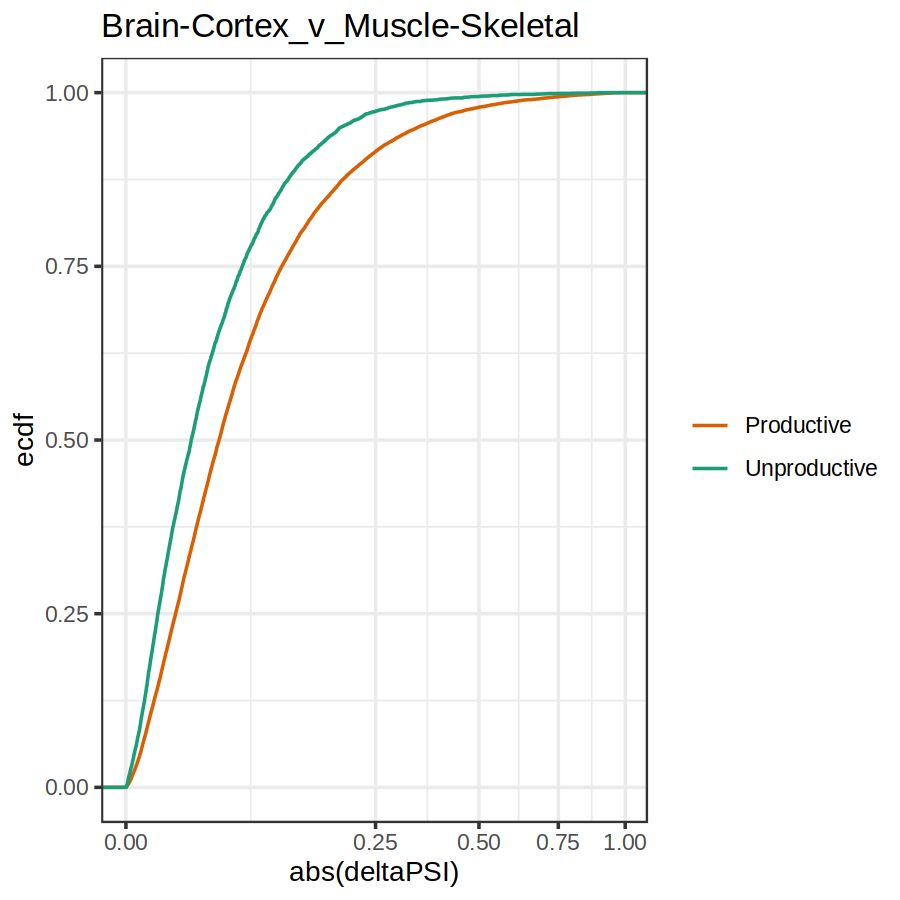

In [27]:
ds[`p.adjust` < FDR & ctype %in% c('PR', 'PR,UP')
  ][,.(intron, deltapsi, itype)] %>% unique %>% 
  ggplot() + stat_ecdf(aes(x=abs(deltapsi), color=itype)) +
    scale_color_brewer(type = "qual", palette = 2, direction = -1, label = c(PR="Productive", UP="Unproductive"), name = NULL) +
    labs(title = glue("{contrast}")) +
    scale_x_sqrt(name = "abs(deltaPSI)") +
    theme_bw()

## Plot deltaPSI vs. log2FC of gene expression

In [28]:
ds[1:5]
ds[deltapsi > .1 & `p.adjust` < FDR, .N]

intron,cluster,itype,ctype,gene_name,gene_id,logef,Muscle-Skeletal,Brain-Cortex,deltapsi,status,loglr,df,p,p.adjust
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
chr1:930336:931038:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,0.001370763,0.5276685,0.5283518,0.0006832305,Success,0.0001028596,1,0.9885564,0.9923067
chr1:931089:935771:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,-0.001370763,0.4723315,0.4716482,-0.0006832305,Success,0.0001028596,1,0.9885564,0.9923067
chr1:939129:939271:clu_12_+,chr1:clu_12_+,PR,PR,SAMD11,ENSG00000187634.11,0.033612392,0.3507898,0.3662486,0.0154587644,Success,0.0288890045,1,0.8100430,0.8467780
chr1:939129:939274:clu_12_+,chr1:clu_12_+,PR,PR,SAMD11,ENSG00000187634.11,-0.033612392,0.6492102,0.6337514,-0.0154587644,Success,0.0288890045,1,0.8100430,0.8467780
chr1:939412:941143:clu_13_+,chr1:clu_13_+,PR,PR,SAMD11,ENSG00000187634.11,-0.022419411,0.2376936,0.2324409,-0.0052526823,Success,1.3652655309,2,0.2553129,0.3191507


[1] 4551

In [29]:
dge[padj < FDR & abs(log2FoldChange) > 1][1:5]
dge[padj < FDR & abs(log2FoldChange) > 1, .N]

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000109061.9,264709.904,-13.54712,0.2173014,-62.34253,0,0
ENSG00000168530.15,109266.143,-13.36231,0.1923248,-69.47785,0,0
ENSG00000125414.18,209656.455,-13.35553,0.2288908,-58.34893,0,0
ENSG00000250978.5,1478.281,-13.28802,0.3241620,-40.99192,0,0
ENSG00000116748.21,14974.113,-13.21024,0.2008433,-65.77385,0,0


[1] 14558

In [30]:
joined_dt <- inner_join(
  x = ds[abs(deltapsi) > .1 & `p.adjust` < FDR & ctype %in% c('PR', 'PR,UP'), 
        .(gene_id, gene_name, intron, cluster, itype, ctype, deltapsi)],
  y = dge[, .(gene_id, g_l2fc = log2FoldChange, g_z = stat, g_l2fcSE = lfcSE)],
  by = 'gene_id'
  )

joined_dt[1:5]
joined_dt[, .(Ngene = uniqueN(gene_id), Nintron = uniqueN(intron))]

gene_id,gene_name,intron,cluster,itype,ctype,deltapsi,g_l2fc,g_z,g_l2fcSE
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188157.14,AGRN,chr1:1022462:1035276:clu_20_+,chr1:clu_20_+,PR,PR,-0.3745532,3.570754,45.75627,0.07803857
ENSG00000188157.14,AGRN,chr1:1034703:1035276:clu_20_+,chr1:clu_20_+,PR,PR,0.3745532,3.570754,45.75627,0.07803857
ENSG00000188157.14,AGRN,chr1:1050837:1051031:clu_21_+,chr1:clu_21_+,PR,PR,0.3625359,3.570754,45.75627,0.07803857
ENSG00000188157.14,AGRN,chr1:1050837:1051252:clu_21_+,chr1:clu_21_+,PR,PR,-0.7500573,3.570754,45.75627,0.07803857
ENSG00000188157.14,AGRN,chr1:1051043:1051252:clu_21_+,chr1:clu_21_+,PR,PR,0.3875214,3.570754,45.75627,0.07803857


Ngene,Nintron
<int>,<int>
3353,8902


### Compute correlation - keep all introns

In [31]:
joined_dt[1:2]

gene_id,gene_name,intron,cluster,itype,ctype,deltapsi,g_l2fc,g_z,g_l2fcSE
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188157.14,AGRN,chr1:1022462:1035276:clu_20_+,chr1:clu_20_+,PR,PR,-0.3745532,3.570754,45.75627,0.07803857
ENSG00000188157.14,AGRN,chr1:1034703:1035276:clu_20_+,chr1:clu_20_+,PR,PR,0.3745532,3.570754,45.75627,0.07803857


### Compute correlation using l2fc

In [32]:
contrast

[1] "Brain-Cortex_v_Muscle-Skeletal"

In [33]:
cor_res <- joined_dt %>% 
  split(by = 'itype') %>% 
  map(~cor.test(x = .x$g_z, y = .x$deltapsi, method = 'pearson')) %>% 
  imap_dfr(
    \(x, y) {
      data.table(
        cor = x$estimate,
        p = x$`p.value`,
        itype = y)
    }
  )

In [36]:
cor_res

cor,p,itype
<dbl>,<dbl>,<chr>
0.02615188,1.922309e-02,PR
-0.15253287,4.977908e-06,UP


In [26]:
options(repr.plot.width=8, repr.plot.height=5)

In [38]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 180)

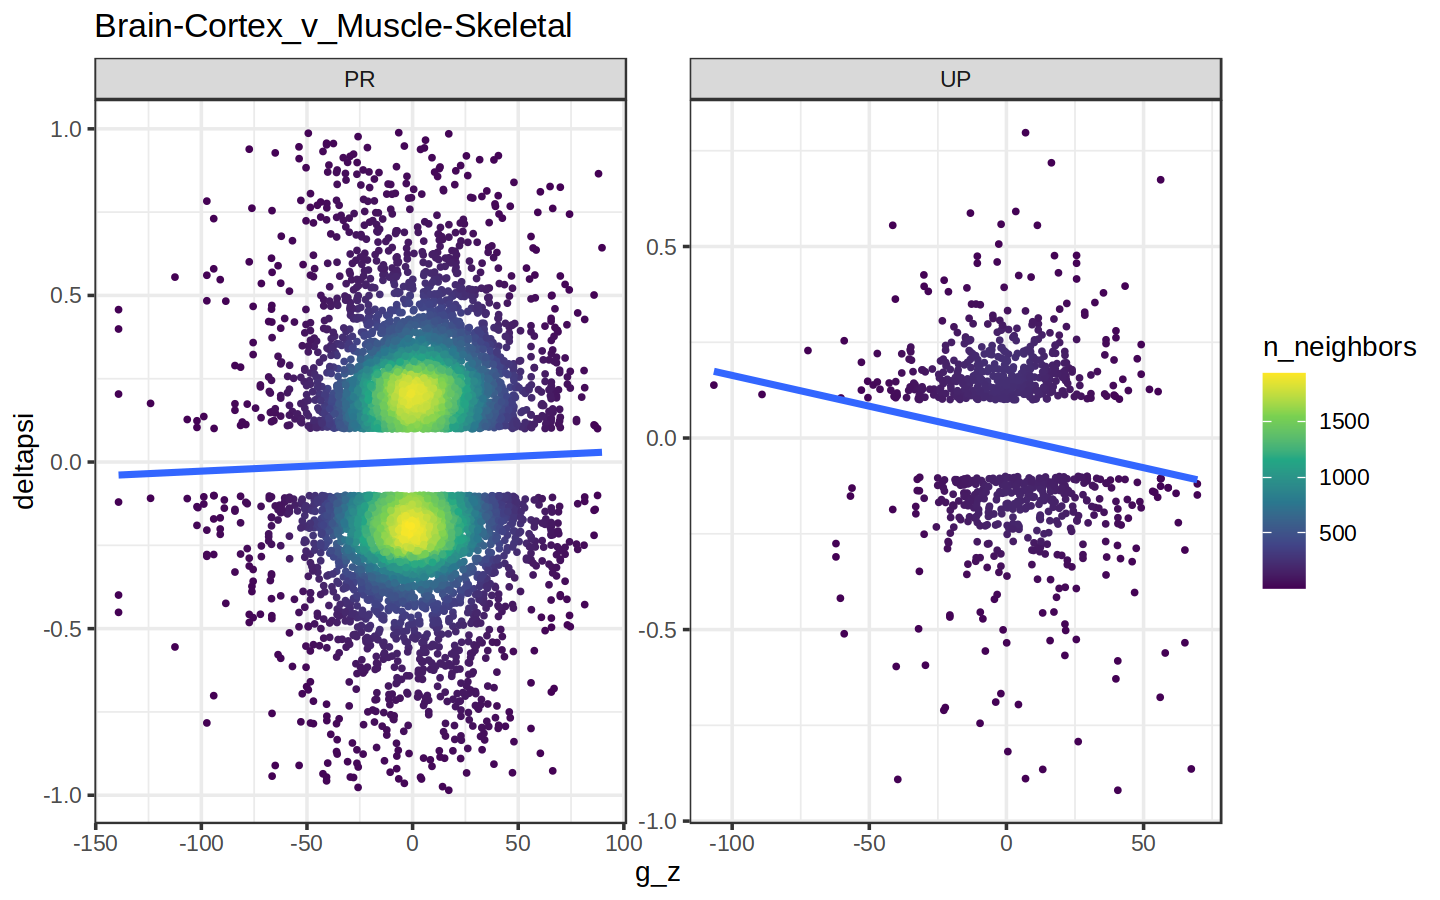

In [39]:
joined_dt %>% 
ggplot() +
geom_pointdensity(aes(g_z, deltapsi), size = .5, ) +
       scale_color_viridis_c() + 
       geom_smooth(aes(g_z, deltapsi), method = "lm", formula = y~x, se = FALSE) +
       labs(title = glue("{contrast}")) +
       theme_bw() +
       facet_wrap(~itype, scales = "free")

# Do a list of contrasts

In [40]:
rds_list = dir('../data/ds_v_dge', pattern = '*.rds', full.names = T)
contrast_list = str_split(rds_list, "/") %>% map(., last) %>% unlist %>% str_remove_all('_data\\.rds')

In [41]:
contrast_list[1:5]
rds_list[1:5]

[1] "Adipose-Visceral_Omentum__v_AdrenalGland"                       
[2] "Adipose-Visceral_Omentum__v_Artery-Coronary"                    
[3] "Adipose-Visceral_Omentum__v_Brain-Amygdala"                     
[4] "Adipose-Visceral_Omentum__v_Brain-Anteriorcingulatecortex_BA24_"
[5] "Adipose-Visceral_Omentum__v_Brain-Caudate_basalganglia_"

[1] "../data/ds_v_dge/Adipose-Visceral_Omentum__v_AdrenalGland_data.rds"                       
[2] "../data/ds_v_dge/Adipose-Visceral_Omentum__v_Artery-Coronary_data.rds"                    
[3] "../data/ds_v_dge/Adipose-Visceral_Omentum__v_Brain-Amygdala_data.rds"                     
[4] "../data/ds_v_dge/Adipose-Visceral_Omentum__v_Brain-Anteriorcingulatecortex_BA24__data.rds"
[5] "../data/ds_v_dge/Adipose-Visceral_Omentum__v_Brain-Caudate_basalganglia__data.rds"

In [42]:
read_contrast <- function(rds, contrast, FDR = 1e-5, selection = 'all') {
  data <- readRDS(rds)
  ds <- data$ds
  dge <- data$dge
  dge_dsc <- data$dge_dsc

  joined_dt <- inner_join(
    x = ds[abs(deltapsi) > .1 & `p.adjust` < FDR & ctype %in% c('PR', 'PR,UP'), 
          .(gene_id, gene_name, intron, cluster, itype, ctype, deltapsi)],
    y = dge[, .(gene_id, g_l2fc = log2FoldChange, g_z = stat, g_l2fcSE = lfcSE)],
    by = 'gene_id'
  )

  if (selection == 'maxClu') {
    joined_dt  <- joined_dt[
      , .(intron, deltapsi, g_l2fc, g_z, g_l2fcSE, rk = rank(-abs(deltapsi), ties.method = "random")), 
      by = .(gene_id, gene_name, cluster, itype, ctype)
      ][rk == 1, -c('rk')]
  } else if (selection == 'maxGene') {
    joined_dt <- joined_dt[
      , .(intron, deltapsi, g_l2fc, g_z, g_l2fcSE, rk = rank(-abs(deltapsi), ties.method = "random")), 
      by = .(gene_id, gene_name, itype)
      ][rk == 1, -c('rk')]
  }

  # run cor.test
  cor_res <- joined_dt %>% 
    split(by = 'itype') %>% 
    map(~cor.test(x = .x$g_z, y = .x$deltapsi, method = 'pearson')) %>% 
    imap_dfr(
      \(x, y) {
        data.table(
          cor = x$estimate,
          p = x$`p.value`,
          itype = y,
          contrast = contrast)
      }
    )

    # plot scatter plot
    p  <- joined_dt %>% 
      ggplot() + 
        geom_pointdensity(aes(g_z, deltapsi), size = .5, alpha = .5) +
        scale_color_viridis_c() + 
        geom_smooth(aes(g_z, deltapsi), method = "lm", formula = y~x, se = FALSE, color = 'blue', lwd = 1) +
        geom_text(aes(x = 0,
                      y = 0.1, 
                      label = paste("cor: ", round(cor, 3), ", ",
                                    "p. val: ", format(p, digits = 3, scientific = T), 
                                    sep = "")
                      ),
                  data = cor_res, color = 'blue', size = 4, vjust = 1) +
        labs(x = "DGE: Z-score", y = "DS: deltaPSI", color = "Num. points", 
             title = str_wrap(str_replace_all(contrast, '_', ' '), width = 40)) +
        facet_wrap(~itype)

    return(list(cor_res = cor_res, gg = p, joineddf = joined_dt))

}

In [43]:
res <- map2(rds_list, contrast_list, read_contrast, FDR = 1e-5, selection = 'maxClu')

In [44]:
df <- map_dfr(res, ~.x$cor_res)

In [45]:
res3 <- map2(rds_list, contrast_list, read_contrast, FDR = 1e-5, selection = 'all', .progress = T)
df3 <- map_dfr(res3, ~.x[['cor_res']])

 ■                                  1% |  ETA:  4m

 ■■                                 3% |  ETA:  4m

 ■■                                 4% |  ETA:  4m

 ■■■                                5% |  ETA:  4m

 ■■■                                6% |  ETA:  4m

 ■■■                                7% |  ETA:  4m

 ■■■                                8% |  ETA:  4m

 ■■■■                              10% |  ETA:  4m

 ■■■■                              11% |  ETA:  4m

 ■■■■■                             12% |  ETA:  4m

 ■■■■■                             14% |  ETA:  4m

 ■■■■■                             15% |  ETA:  3m

 ■■■■■■                            16% |  ETA:  3m

 ■■■■■■                            18% |  ETA:  3m

 ■■■■■■■                           19% |  ETA:  3m

 ■■■■■■■                           20% |  ETA:  3m

 ■■■■■■■                           22% |  ETA:  3m



 ■■■■■■■■                          23% |  ETA:  3m

 ■■■■■■■■                          24% |  ETA:  3m

 ■■■■■■■■                          25% |  ETA:  3m

 ■■■■■■■■■                         26% |  ETA:  3m

 ■■■■■■■■■                         27% |  ETA:  3m

 ■■■■■■■■■■                        29% |  ETA:  3m

 ■■■■■■■■■■                        30% |  ETA:  3m

 ■■■■■■■■■■                        31% |  ETA:  3m

 ■■■■■■■■■■■                       33% |  ETA:  3m

 ■■■■■■■■■■■                       34% |  ETA:  3m

 ■■■■■■■■■■■■                      36% |  ETA:  3m

 ■■■■■■■■■■■■                      37% |  ETA:  2m

 ■■■■■■■■■■■■                      38% |  ETA:  2m

 ■■■■■■■■■■■■■                     40% |  ETA:  2m

 ■■■■■■■■■■■■■                     41% |  ETA:  2m

 ■■■■■■■■■■■■■■                    42% |  ETA:  2m

 ■■■■■■■■■■■■■■                    44% |  ETA:  2m

 ■■■■■■■■■■■■■■■                   45% |  ETA:  2m

 ■■■■■■■■■■■■■■■                   46% |  ETA:  2m

 ■■■■■■■■■■■

In [48]:
gg1 <- df %>% 
  ggplot() + geom_point(aes(cor, -log10(p), color = itype), size = .5, alpha = .9) +
  scale_color_brewer(type = "qual", palette = 1, direction = 1, label = c(PR="Productive", UP="Unproductive"), name = NULL) +
  lims(x = c(-.5, .2), y = c(0, 30)) +
  geom_hline(yintercept = -log10(0.001), linetype = 2) +
    labs(color = NULL, title = "Choose 1 max intron per cluster")

In [49]:
gg3 <- df3 %>% 
  ggplot() + geom_pointdensity(aes(cor, -log10(p), color = itype), size = .5, alpha = .9) +
  scale_color_brewer(type = "qual", palette = 1, direction = 1, label = c(PR="Productive", UP="Unproductive"), name = NULL) +
  lims(x = c(-.5, .2), y = c(0, 30)) +
  geom_hline(yintercept = -log10(0.001), linetype = 2) +
    labs(color = NULL, title = "Choose all introns")

In [54]:
options(repr.plot.width=12, repr.plot.height=5)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_pointdensity()`).”


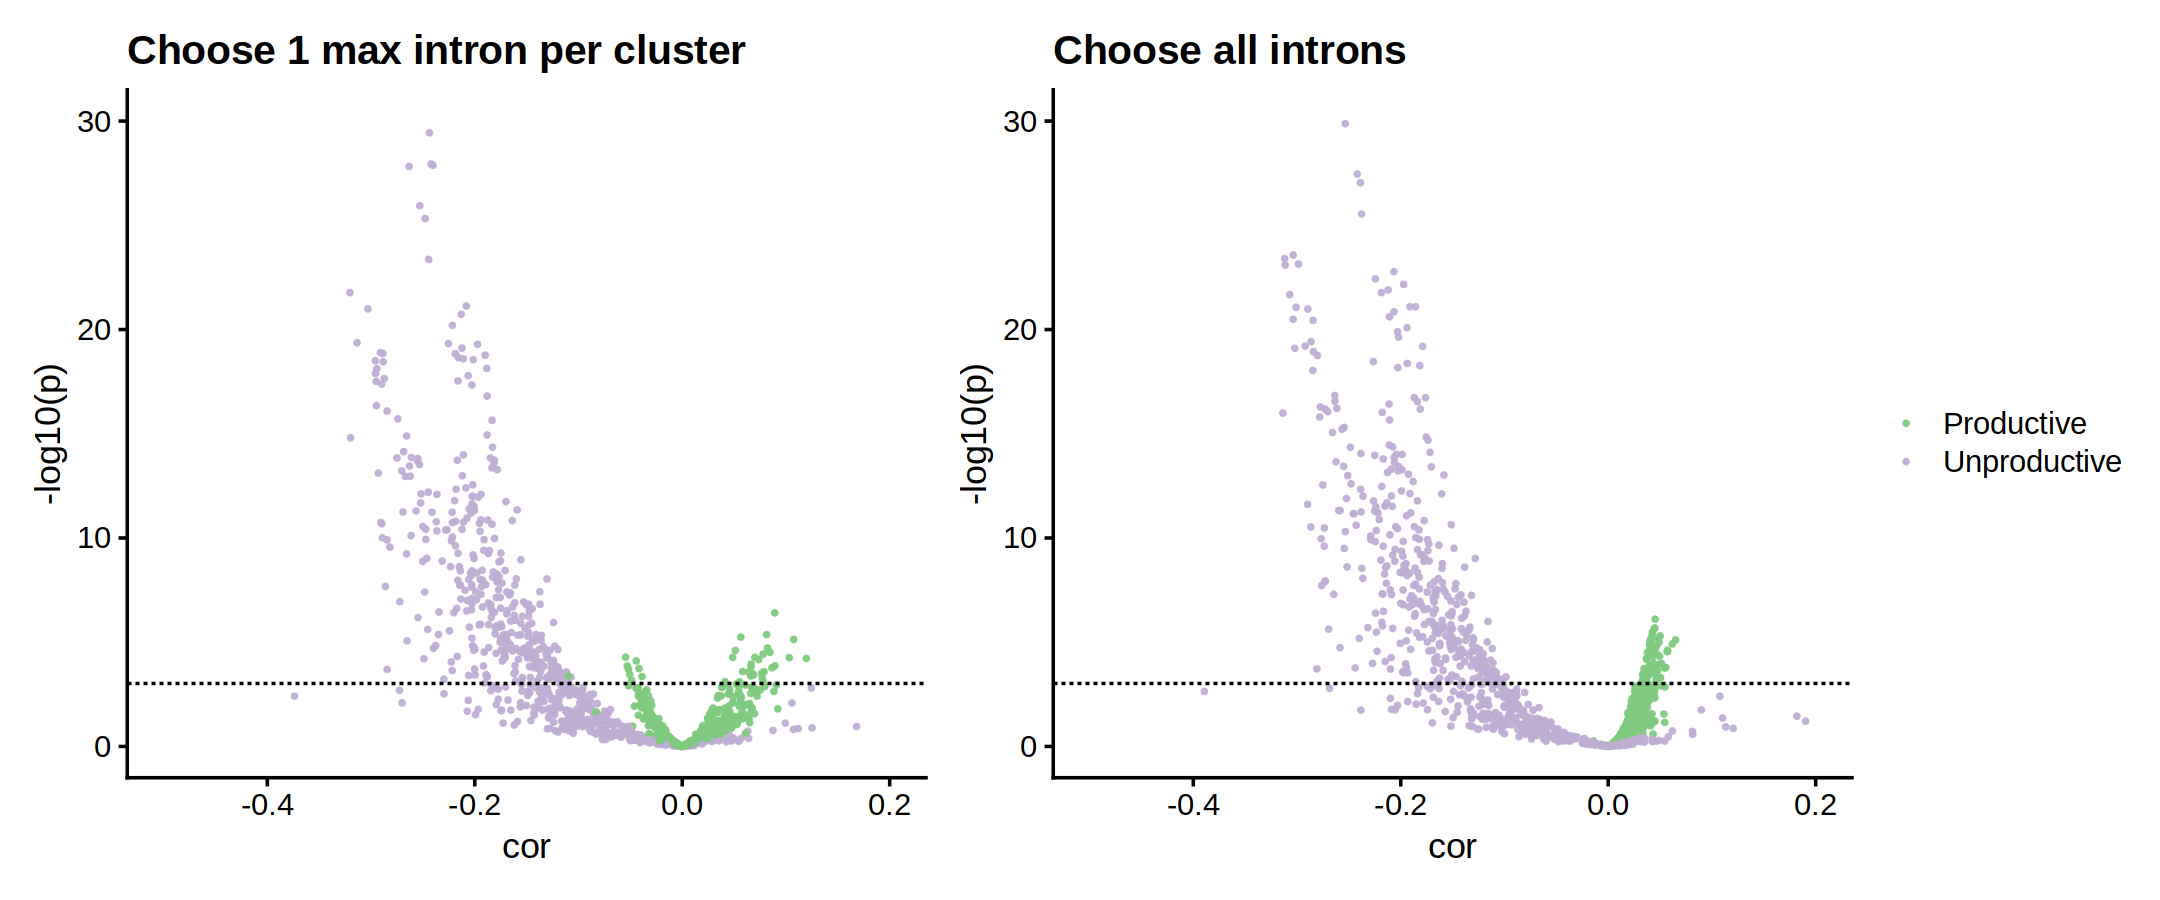

In [55]:
gg1 + gg3 + 
  plot_layout(guides = 'collect')

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_pointdensity()`).”


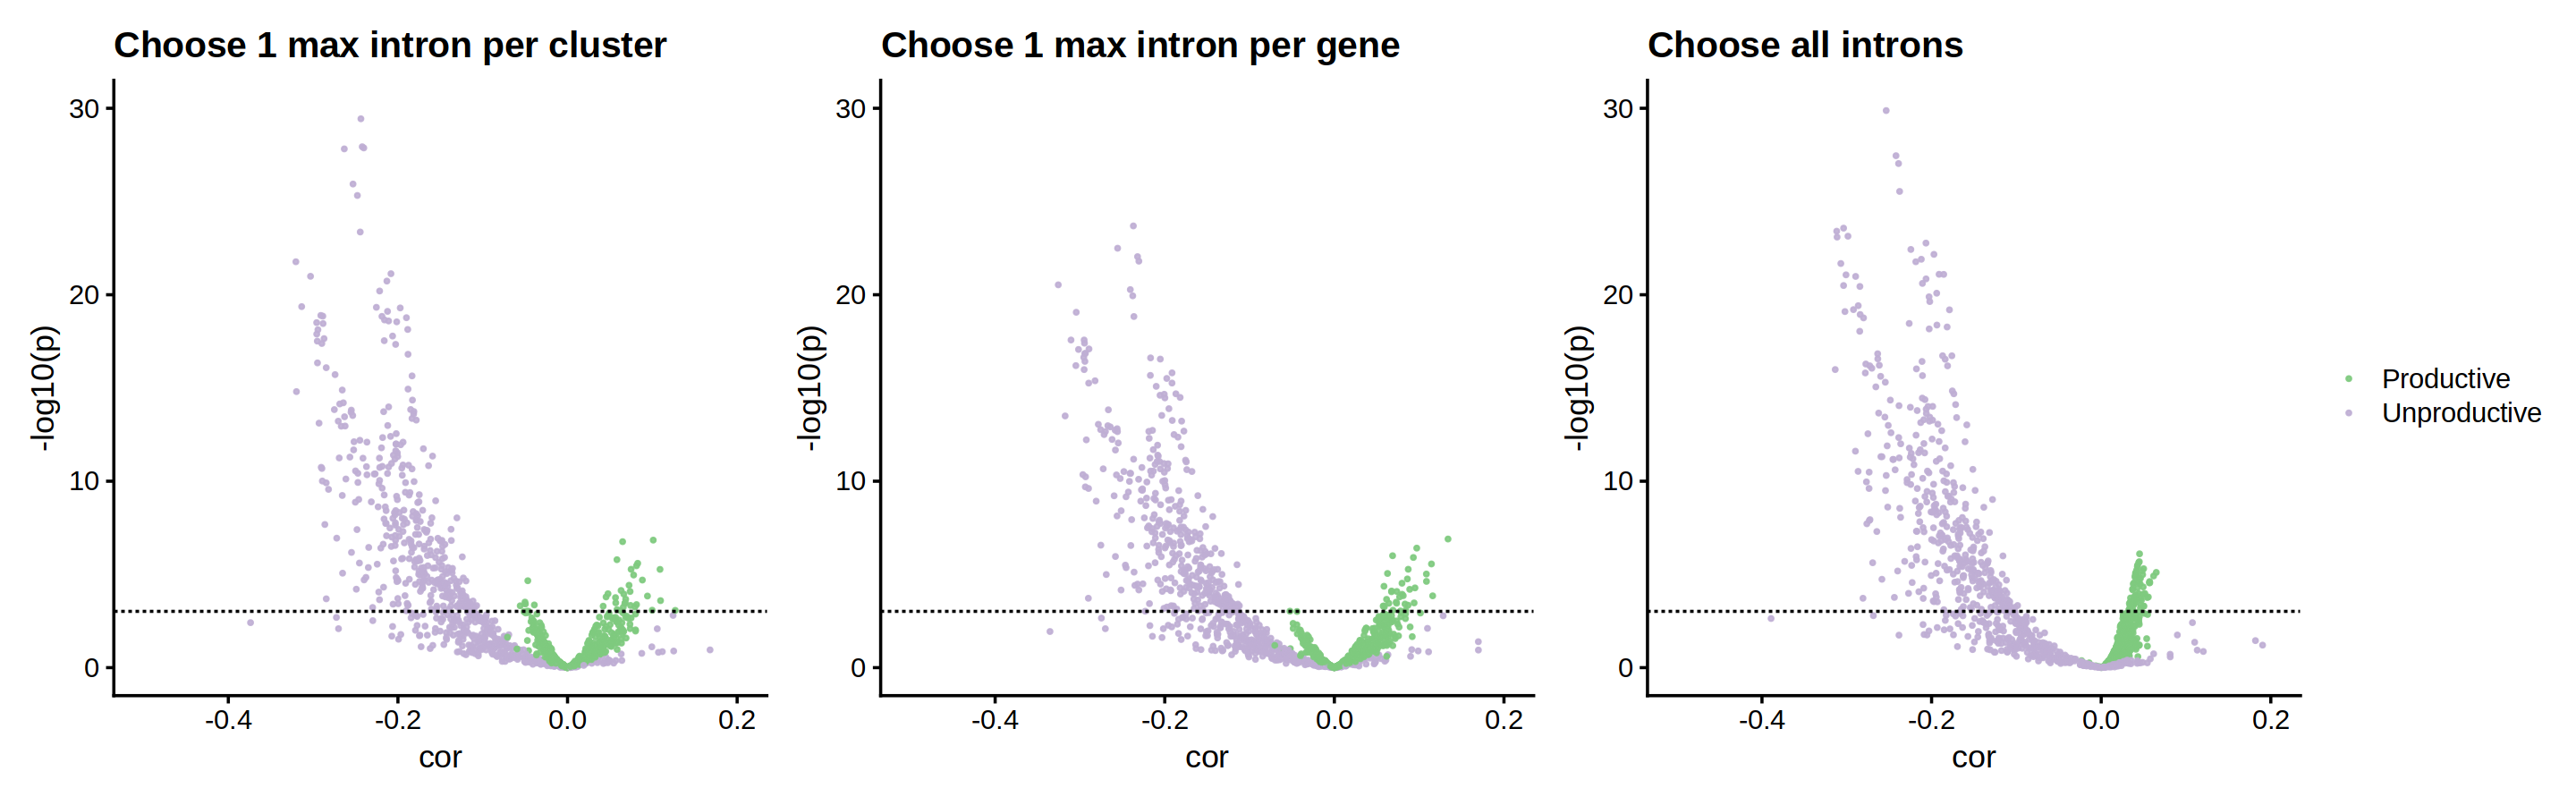

In [ ]:
gg1 + gg2 + gg3 + 
  plot_layout(guides = 'collect')

Warning message:
“Removed 3 rows containing non-finite values (`stat_pointdensity()`).”


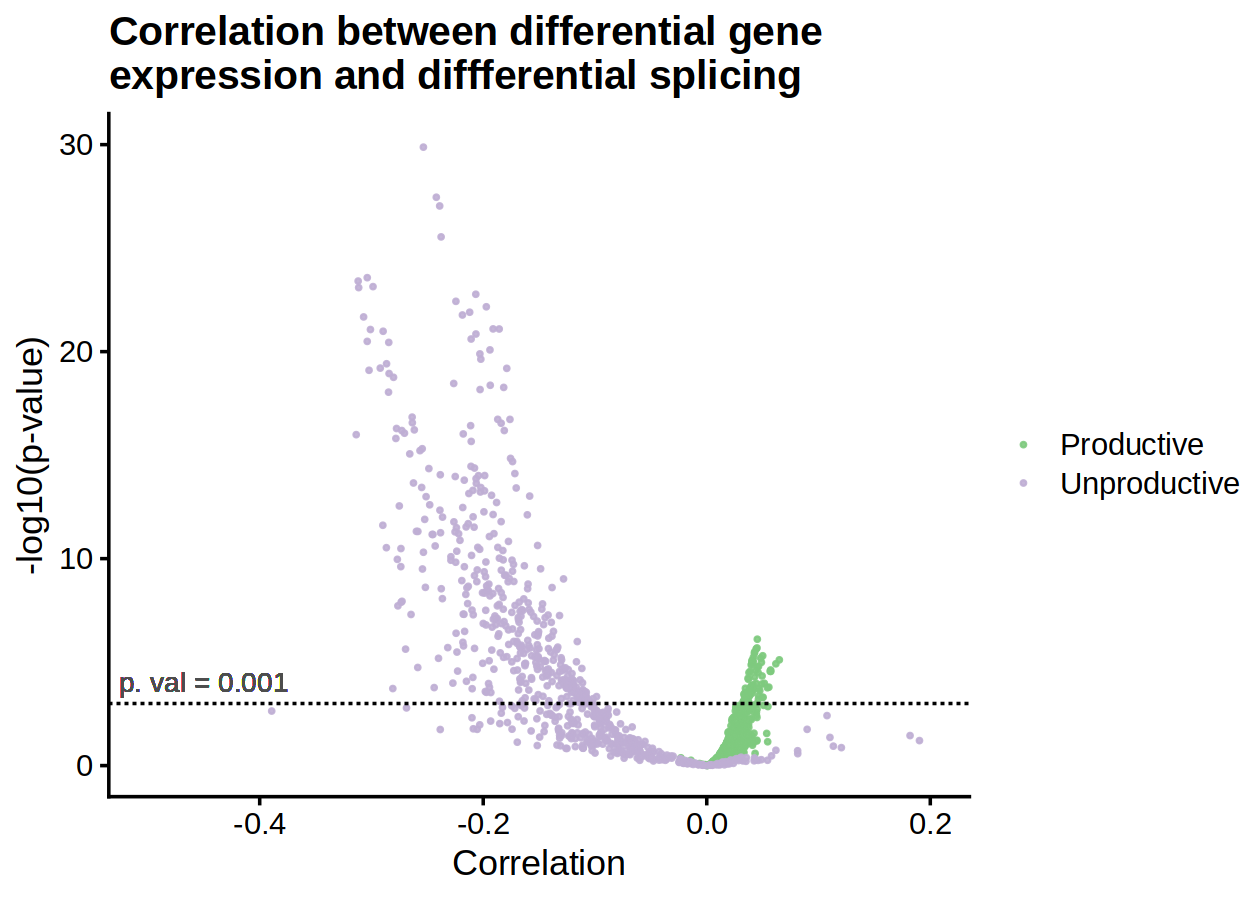

In [56]:
options(repr.plot.width=7, repr.plot.height=5)
gg3 +
  geom_text(aes(x = -.45, y = 4, label = "p. val = 0.001"), color = 'grey30') +
  labs(title = 'Correlation between differential gene\nexpression and diffferential splicing', x = 'Correlation', y = '-log10(p-value)')

In [57]:
has_bw = c('Brain-Cortex_v_Kidney-Cortex',
'Brain-Cortex_v_Lung',
'Lung_v_Muscle-Skeletal')

In [58]:
df3[contrast %in% has_bw[1]]

cor,p,itype,contrast
<dbl>,<dbl>,<chr>,<chr>
-0.25657567,6.088113e-16,UP,Brain-Cortex_v_Kidney-Cortex
0.03589999,7.109547e-04,PR,Brain-Cortex_v_Kidney-Cortex


In [59]:
df3[contrast %in% has_bw[2]]

cor,p,itype,contrast
<dbl>,<dbl>,<chr>,<chr>
-0.22504081,1.082266e-14,UP,Brain-Cortex_v_Lung
0.03020497,3.406589e-03,PR,Brain-Cortex_v_Lung


### Check if using max intron per cluster is better than using all introns

In [322]:
options(repr.plot.width=10, repr.plot.height=5)

In [356]:
box1 <- inner_join(
  x = df[p < 1e-3][order(-abs(cor))],
y = df3[p < 1e-3][order(-abs(cor))],
by = c('itype', 'contrast'),
suffix = c('_maxClu', '_all')
) %>% 
.[, .(contrast, itype, delta_cor = cor_maxClu - cor_all)]  %>% 
ggplot() + geom_boxplot(aes(itype, delta_cor), width = .2) +
  labs(title = "Difference in correlation between maxClu and all introns") +
  lims(y = c(-.05, .05))+
  theme_bw()


In [357]:
box2 <- inner_join(
          x = df2[p < 1e-3][order(-abs(cor))],
          y = df3[p < 1e-3][order(-abs(cor))],
          by = c('itype', 'contrast'),
          suffix = c('_maxGene', '_all')
          ) %>% 
          .[, .(contrast, itype, delta_cor = cor_maxGene - cor_all)]  %>% 
          ggplot() + geom_boxplot(aes(itype, delta_cor), width = .2) +
            labs(title = "Difference in correlation between maxGene and all introns") +
            lims(y = c(-.05, .05))+
            theme_bw()


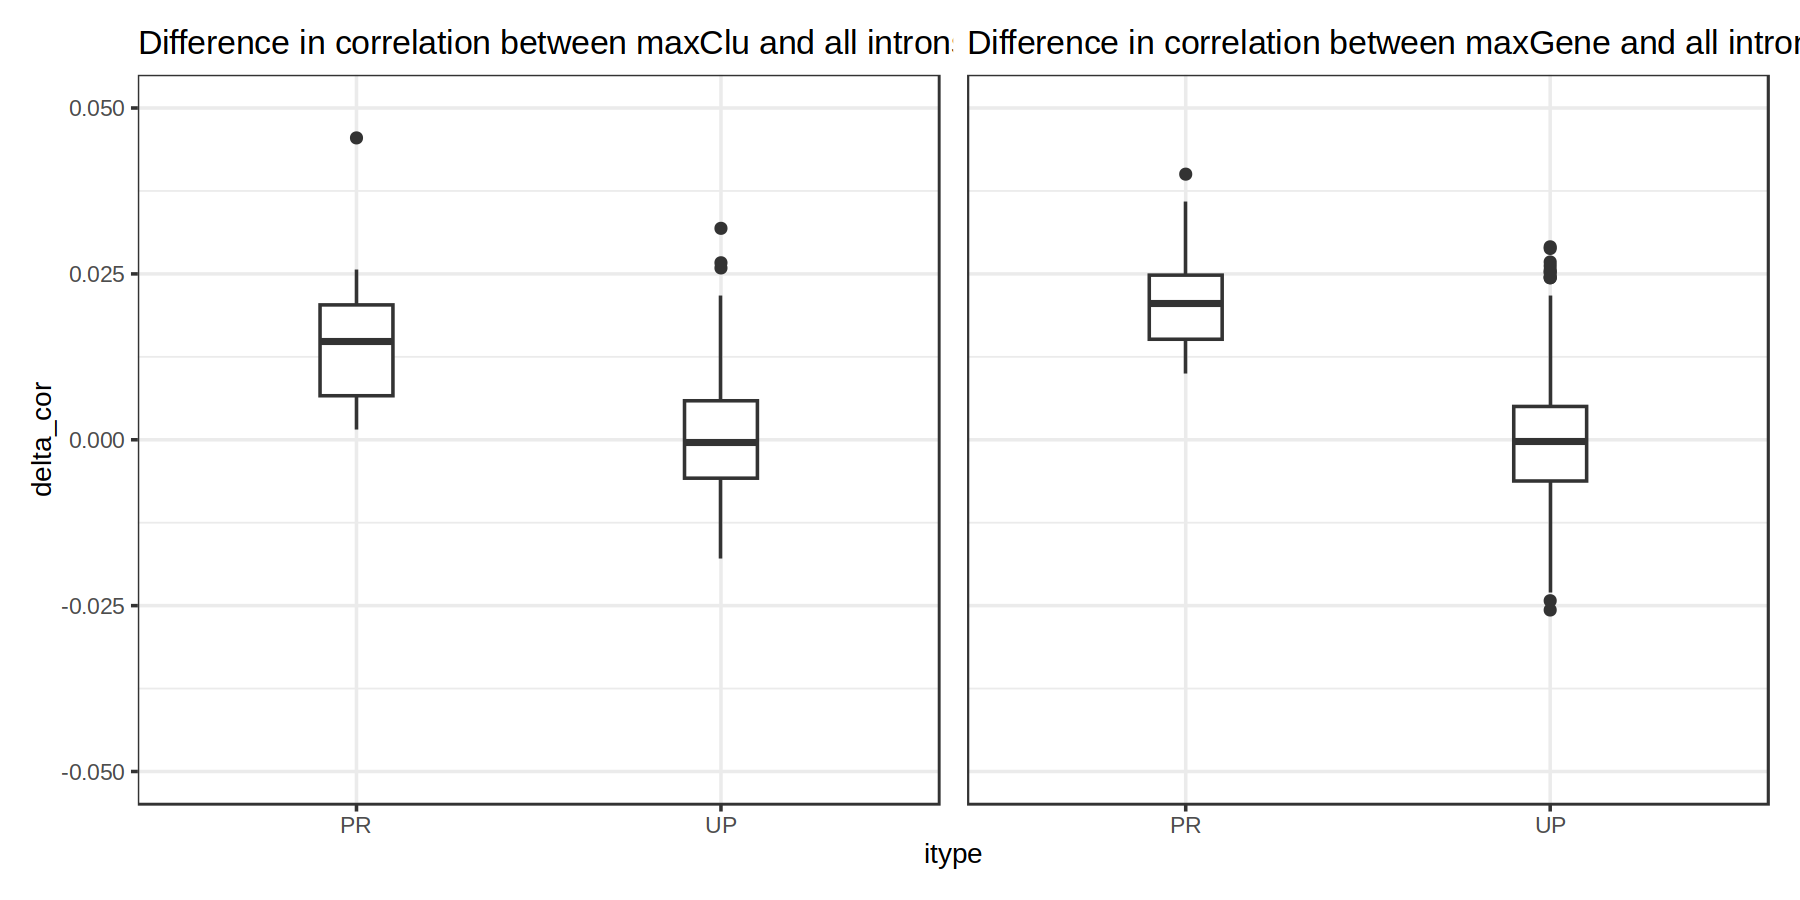

In [359]:
box1+box2 + 
  plot_layout(axes = 'collect')

In [60]:
contrast_list[[241]]

[1] "Brain-Cortex_v_Kidney-Cortex"

In [61]:
options(repr.plot.width=7, repr.plot.height=5)
res = read_contrast(rds_list[241], contrast_list[241])

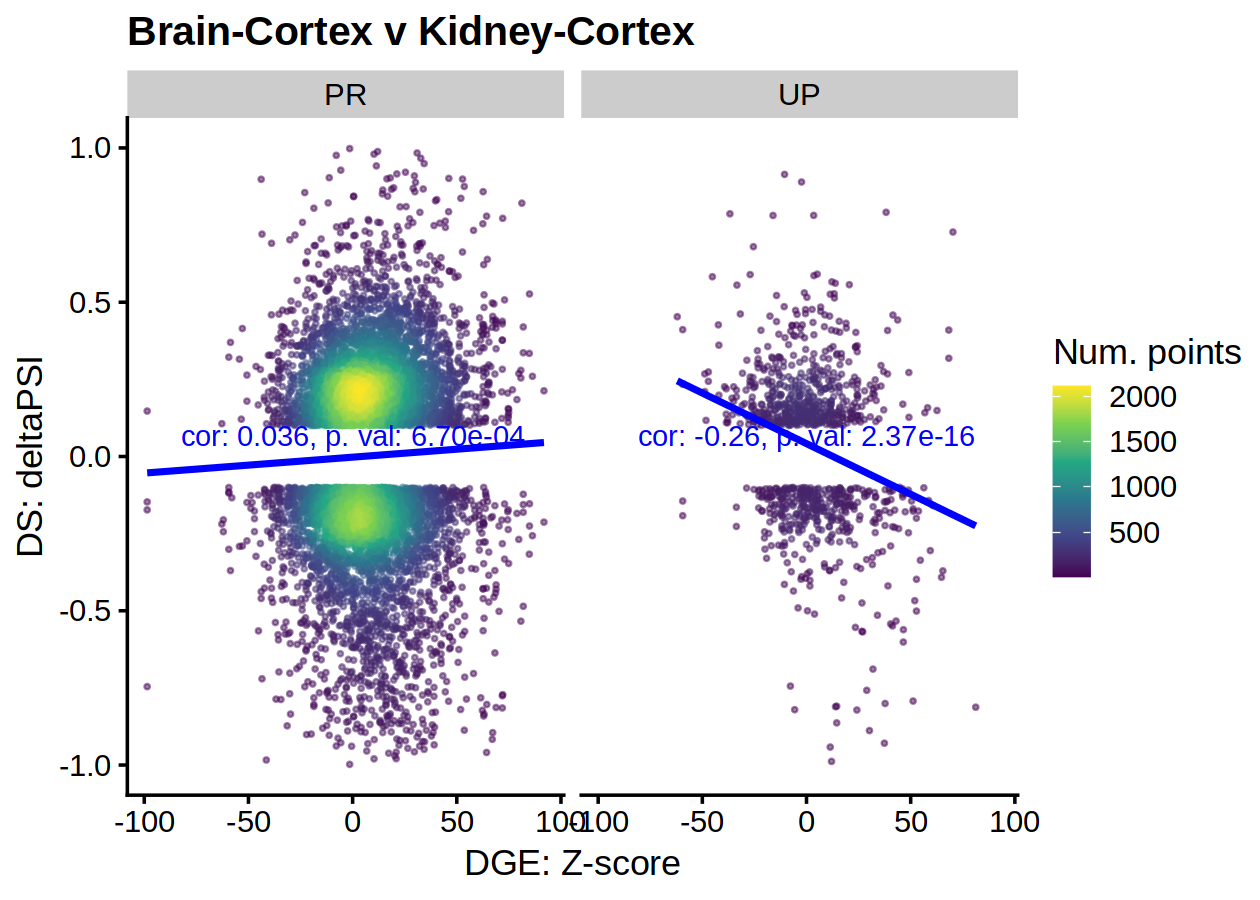

In [20]:
res$gg

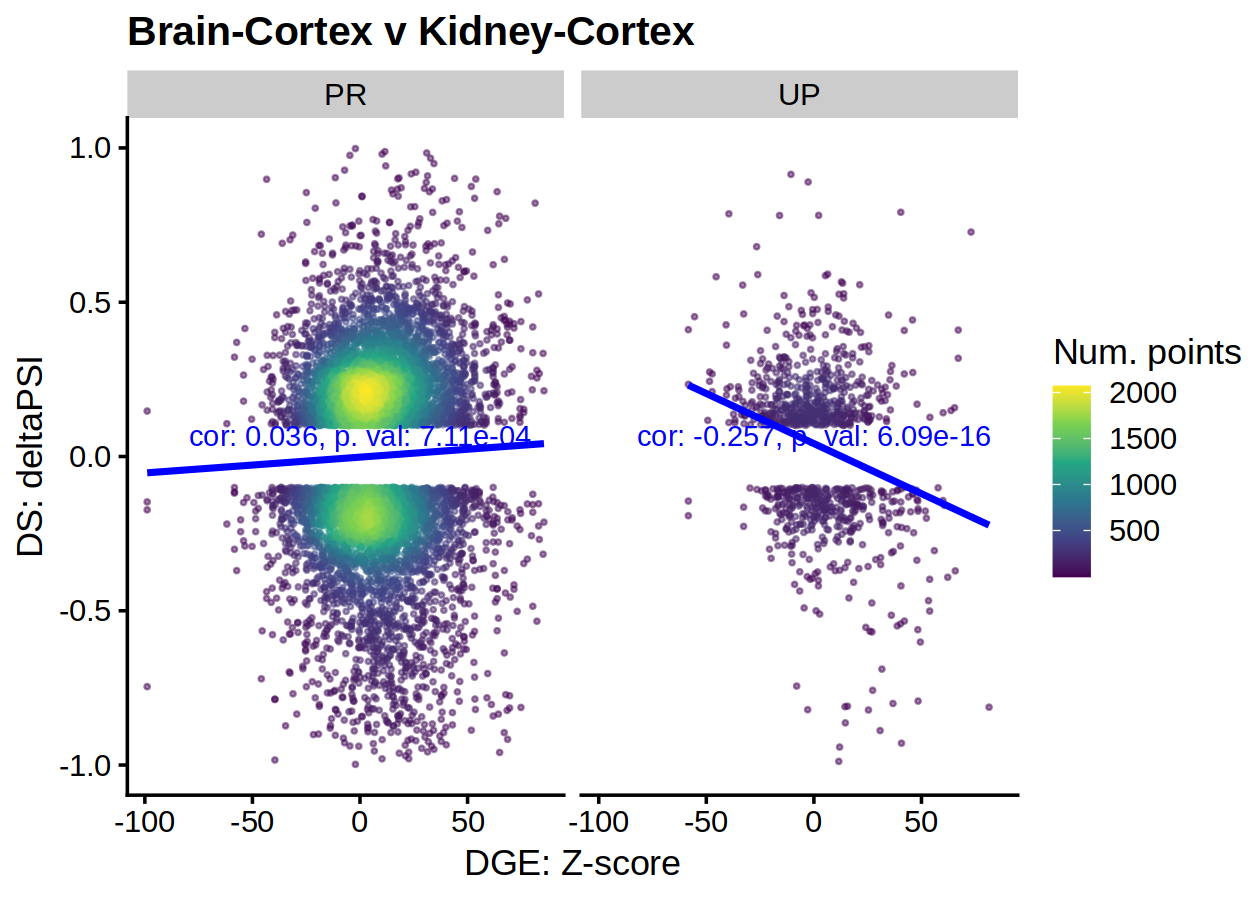

In [62]:
res$gg

In [22]:
names(res)

[1] "cor_res"  "gg"       "joineddf"

In [23]:
res$cor_res

cor,p,itype,contrast
<dbl>,<dbl>,<chr>,<chr>
-0.26006975,2.372114e-16,UP,Brain-Cortex_v_Kidney-Cortex
0.03607129,6.702124e-04,PR,Brain-Cortex_v_Kidney-Cortex


In [27]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [59]:
df$contrast[1:15] %>% str_split("_v_") %>% map(1) %>% str

List of 15
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"
 $ : chr "Adipose-Visceral_Omentum_"


In [63]:
all_tissues <- union(df$contrast %>% str_split("_v_") %>% map_chr(1), df$contrast %>% str_split("_v_") %>% map_chr(2))

In [70]:
mx <-  matrix(rep(NA, length(all_tissues)*length(all_tissues)), nrow = length(all_tissues))

In [79]:
rownames(mx) <- all_tissues
colnames(mx) <- all_tissues
diag(mx) <- 1

In [99]:
vals <- map(all_tissues,
    \(x) {
      map_dbl(all_tissues, 
          \(xx) {
            contr = glue("{x}_v_{xx}")
            if (contr %in% df$contrast) {
              corv = df[contrast == contr & itype == 'UP', cor]
            } else {
              corv = NA
            }
            return(corv)
          }
          )
    }
) %>% as.data.table

In [101]:
rownames(vals) <- all_tissues
colnames(vals) <- all_tissues

In [103]:
diag(vals) <- 1

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


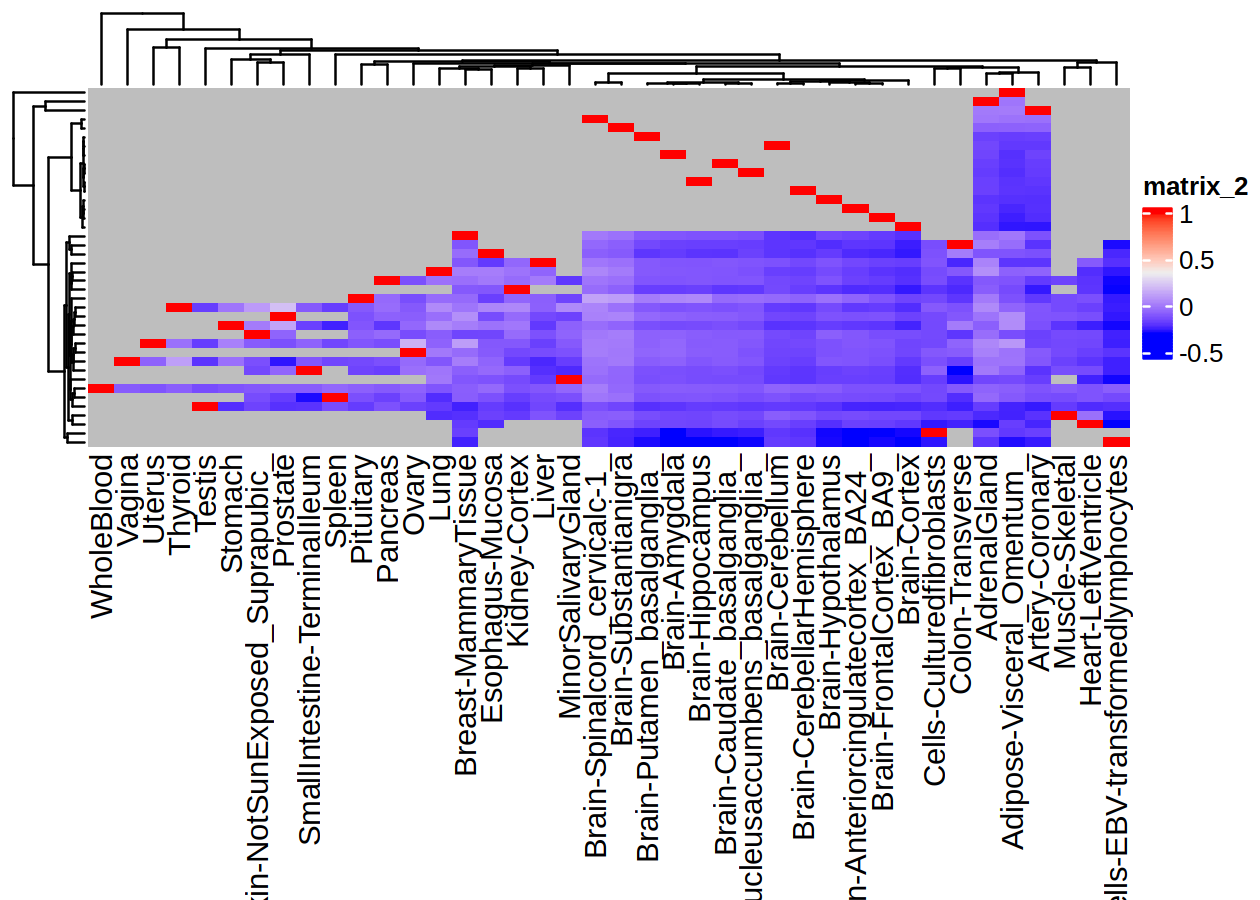

In [107]:
Heatmap(vals)

In [106]:
df[str_detect(contrast, 'Liver') & str_detect(contrast, 'Caudate') & itype == 'UP']

cor,p,itype,contrast
<dbl>,<dbl>,<chr>,<chr>
-0.1060421,0.002087464,UP,Brain-Caudate_basalganglia__v_Liver


In [104]:
vals

,Adipose-Visceral_Omentum_,AdrenalGland,Artery-Coronary,Brain-Amygdala,Brain-Anteriorcingulatecortex_BA24_,Brain-Caudate_basalganglia_,Brain-CerebellarHemisphere,Brain-Cerebellum,Brain-Cortex,Brain-FrontalCortex_BA9_,⋯,Prostate,Skin-NotSunExposed_Suprapubic_,SmallIntestine-TerminalIleum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,WholeBlood
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adipose-Visceral_Omentum_,1.000000000,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AdrenalGland,-0.015830399,1.000000000,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Artery-Coronary,0.003347724,-0.001657056,1.00000000,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Brain-Amygdala,-0.214446409,-0.157919518,-0.16365375,1.00000000,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Brain-Anteriorcingulatecortex_BA24_,-0.237103745,-0.192439738,-0.21489603,NA,1.00000000,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Brain-Caudate_basalganglia_,-0.209430251,-0.174076423,-0.18033136,NA,NA,1.00000000,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Brain-CerebellarHemisphere,-0.203522387,-0.170817609,-0.20754075,NA,NA,NA,1.00000000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Brain-Cerebellum,-0.191035337,-0.152871280,-0.19126019,NA,NA,NA,NA,1.00000000,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Brain-Cortex,-0.268610534,-0.216181689,-0.27037167,NA,NA,NA,NA,NA,1.0000000,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [87]:
df[contrast == 'Adipose-Visceral_Omentum__v_Artery-Coronary' & itype == 'UP', cor] %>% str

 num 0.00335


In [83]:
df[1:5]

cor,p,itype,contrast
<dbl>,<dbl>,<chr>,<chr>
0.006865554,7.854259e-01,PR,Adipose-Visceral_Omentum__v_AdrenalGland
-0.015830399,8.170640e-01,UP,Adipose-Visceral_Omentum__v_AdrenalGland
0.004107959,9.142241e-01,PR,Adipose-Visceral_Omentum__v_Artery-Coronary
0.003347724,9.780571e-01,UP,Adipose-Visceral_Omentum__v_Artery-Coronary
-0.214446409,1.836448e-08,UP,Adipose-Visceral_Omentum__v_Brain-Amygdala


In [62]:
df[itype == 'UP'][p < 1e-10
][, .(cor, contrast, a = str_split(contrast, "_v_") %>% map_chr(1), b = str_split(contrast, "_v_") %>% map_chr(2))]

cor,contrast,a,b
<dbl>,<chr>,<chr>,<chr>
-0.2371037,Adipose-Visceral_Omentum__v_Brain-Anteriorcingulatecortex_BA24_,Adipose-Visceral_Omentum_,Brain-Anteriorcingulatecortex_BA24_
-0.2035224,Adipose-Visceral_Omentum__v_Brain-CerebellarHemisphere,Adipose-Visceral_Omentum_,Brain-CerebellarHemisphere
-0.2686105,Adipose-Visceral_Omentum__v_Brain-Cortex,Adipose-Visceral_Omentum_,Brain-Cortex
-0.2533146,Adipose-Visceral_Omentum__v_Brain-FrontalCortex_BA9_,Adipose-Visceral_Omentum_,Brain-FrontalCortex_BA9_
-0.2444524,Adipose-Visceral_Omentum__v_Testis,Adipose-Visceral_Omentum_,Testis
-0.1814816,AdrenalGland_v_Testis,AdrenalGland,Testis
-0.2075408,Artery-Coronary_v_Brain-CerebellarHemisphere,Artery-Coronary,Brain-CerebellarHemisphere
-0.2703717,Artery-Coronary_v_Brain-Cortex,Artery-Coronary,Brain-Cortex
-0.2215809,Artery-Coronary_v_Brain-FrontalCortex_BA9_,Artery-Coronary,Brain-FrontalCortex_BA9_
